In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [45]:
from copy import deepcopy
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.models.frame_level import FrameLevelLexicalAccess, LexicalAccessDataCollator
from src.models.rnn import ExposedLSTM

In [6]:
dataset_path = "data/timit_phoneme"
model_checkpoint_path = "outputs/outputs_dualhead0.5/models/w2v2_drop6_rnn/checkpoint-5150/"
model_sfreq = 50
tokenizer_name = "charsiu/tokenizer_en_cmu"

In [7]:
test_dataset = datasets.load_from_disk(dataset_path)

In [8]:
model: FrameLevelLexicalAccess = FrameLevelLexicalAccess.from_pretrained(model_checkpoint_path)

tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Model surgery: swap in exposed LSTM

In [9]:
collator = LexicalAccessDataCollator(
    processor=processor,
    model=model,
    padding=True,
    num_labels=model.config.num_labels,
    regression_target_size=model.config.regressor_target_size,
)

/userdata/jgauthier/projects/ideal-word-representations/src/models/frame_level.py:244: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets[i][onset:offset, :] = torch.tensor(self.model.word_representations[word_id])


In [11]:
# dev_batch = collator(test_dataset["test"].select(range(2)))
#
# with torch.no_grad():
#     dev_forward_orig = model(**dev_batch)

In [13]:
rnn_state = deepcopy(model.rnn.state_dict())
exposed_lstm = ExposedLSTM(
    input_size=model.rnn.input_size,
    hidden_size=model.rnn.hidden_size,
    num_layers=model.rnn.num_layers,
    bias=model.rnn.bias,
    batch_first=model.rnn.batch_first,
)
exposed_lstm.load_state_dict(rnn_state)

model.rnn = exposed_lstm
model.config.expose_rnn = True

In [30]:
# with torch.no_grad():
#     dev_forward = model(output_hidden_states=True, **dev_batch)
#
# assert torch.allclose(dev_forward_orig.rnn_hidden_states,
#                       dev_forward.rnn_hidden_states[0][-1],
#                       rtol=1e-4, atol=1e-6)

## Collect forward pass representations on test set

In [ ]:
def add_indices(item, idx):
    item["idx"] = idx
    return item
test_dataset = test_dataset.map(add_indices, batched=True, batch_size=2000, with_indices=True)

In [145]:
test_dataset_sub = test_dataset["test"]

In [146]:
# Flat representation of all hidden states etc.
flat_idxs = []
hidden_states, cell_states, input_gates, forget_gates, cell_gates, output_gates = \
    [], [], [], [], [], []

dataloader = DataLoader(test_dataset_sub, batch_size=8,
                        collate_fn=collator, shuffle=False)
for batch in tqdm(dataloader):
    with torch.no_grad():
        batch_output = model(output_hidden_states=True, **batch)

    batch_hidden, batch_cell, batch_input_gate, batch_forget_gate, batch_cell_gate, batch_output_gate = \
        batch_output.rnn_hidden_states
    batch_hidden = batch_hidden.permute(1, 2, 0, 3)
    batch_cell = batch_cell.permute(1, 2, 0, 3)
    batch_input_gate = batch_input_gate.permute(1, 2, 0, 3)
    batch_forget_gate = batch_forget_gate.permute(1, 2, 0, 3)
    batch_cell_gate = batch_cell_gate.permute(1, 2, 0, 3)
    batch_output_gate = batch_output_gate.permute(1, 2, 0, 3)

    # we are now in batch * seq_len * num_layers * hidden_size

    real_frames = batch.target_mask.sum(dim=1)
    for i, (idx) in enumerate(batch.idx):
        real_frames_i = real_frames[i]
        flat_idxs.extend([(idx.item(), i) for i in range(real_frames_i)])
        hidden_states.append(batch_hidden[i, :real_frames_i])
        cell_states.append(batch_cell[i, :real_frames_i])
        input_gates.append(batch_input_gate[i, :real_frames_i])
        forget_gates.append(batch_forget_gate[i, :real_frames_i])
        cell_gates.append(batch_cell_gate[i, :real_frames_i])
        output_gates.append(batch_output_gate[i, :real_frames_i])

  0%|          | 0/210 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/models/frame_level.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets[i][onset:offset, :] = torch.tensor(self.model.word_representations[word_id])
Unused kwargs: {'idx': tensor([0, 1, 2, 3, 4, 5, 6, 7])}
Unused kwargs: {'idx': tensor([ 8,  9, 10, 11, 12, 13, 14, 15])}
Unused kwargs: {'idx': tensor([16, 17, 18, 19, 20, 21, 22, 23])}
Unused kwargs: {'idx': tensor([24, 25, 26, 27, 28, 29, 30, 31])}
Unused kwargs: {'idx': tensor([32, 33, 34, 35, 36, 37, 38, 39])}
Unused kwargs: {'idx': tensor([40, 41, 42, 43, 44, 45, 46, 47])}
Unused kwargs: {'idx': tensor([48, 49, 50, 51, 52, 53, 54, 55])}
Unused kwargs: {'idx': tensor([56, 57, 58, 59, 60, 61, 62, 63])}
Unused kwargs: {'idx': tensor([64, 65, 66, 67, 68, 69, 70, 71])}
Unused kwargs: {'idx': tensor([72, 73, 74, 75, 76, 77

In [147]:
hidden_states = torch.cat(hidden_states, dim=0).numpy()
cell_states = torch.cat(cell_states, dim=0).numpy()
input_gates = torch.cat(input_gates, dim=0).numpy()
forget_gates = torch.cat(forget_gates, dim=0).numpy()
cell_gates = torch.cat(cell_gates, dim=0).numpy()
output_gates = torch.cat(output_gates, dim=0).numpy()

In [148]:
assert len(flat_idxs) == len(hidden_states)

In [149]:
boundary_event_names = ["file", "phoneme", "word"]
boundary_event_to_idx = {event_name: i for i, event_name in enumerate(boundary_event_names)}
boundary_matrix = np.zeros((hidden_states.shape[0], len(boundary_event_names)))
hidden_state_source_to_flat_idx = {idx: i for i, idx in enumerate(flat_idxs)}

def add_boundaries(item, idx, boundary_matrix, boundary_event_to_idx, hidden_state_source_to_flat_idx):
    compression_ratio = (model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()

    file_start_idx = hidden_state_source_to_flat_idx[(idx, 0)]
    boundary_matrix[file_start_idx, boundary_event_to_idx["file"]] = 1

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = int(word[0]["start"] * compression_ratio)
        word_start_idx = hidden_state_source_to_flat_idx[(idx, word_start)]
        boundary_matrix[word_start_idx, boundary_event_to_idx["word"]] = 1

        for phoneme in word:
            phoneme_start = int(phoneme["start"] * compression_ratio)
            phoneme_start_idx = hidden_state_source_to_flat_idx[(idx, phoneme_start)]
            boundary_matrix[phoneme_start_idx, boundary_event_to_idx["phoneme"]] = 1

    return None

test_dataset_sub.map(add_boundaries, batched=False, with_indices=True,
                     fn_kwargs={"boundary_matrix": boundary_matrix, "boundary_event_to_idx": boundary_event_to_idx,
                                "hidden_state_source_to_flat_idx": hidden_state_source_to_flat_idx})

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'idx'],
    num_rows: 1680
})

In [207]:
from src.analysis.trf import estimate_trf_cv

## Gate norm time series analysis

In [150]:
gate_norms = np.concatenate([
    np.linalg.norm(input_gates, axis=2),
    np.linalg.norm(forget_gates, axis=2),
    np.linalg.norm(cell_gates, axis=2),
    np.linalg.norm(output_gates, axis=2),
], axis=1)
gate_norm_labels = [f"{gate_name} {layer_idx}"
                    for gate_name in ["input", "forget", "cell", "output"]
                    for layer_idx in range(model.rnn.num_layers)]

In [212]:
trf_df = estimate_trf_cv(boundary_matrix, gate_norms, gate_norm_labels,
                         tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

In [214]:
trf_df[["gate", "layer"]] = trf_df["output_name"].str.split(" ", expand=True)

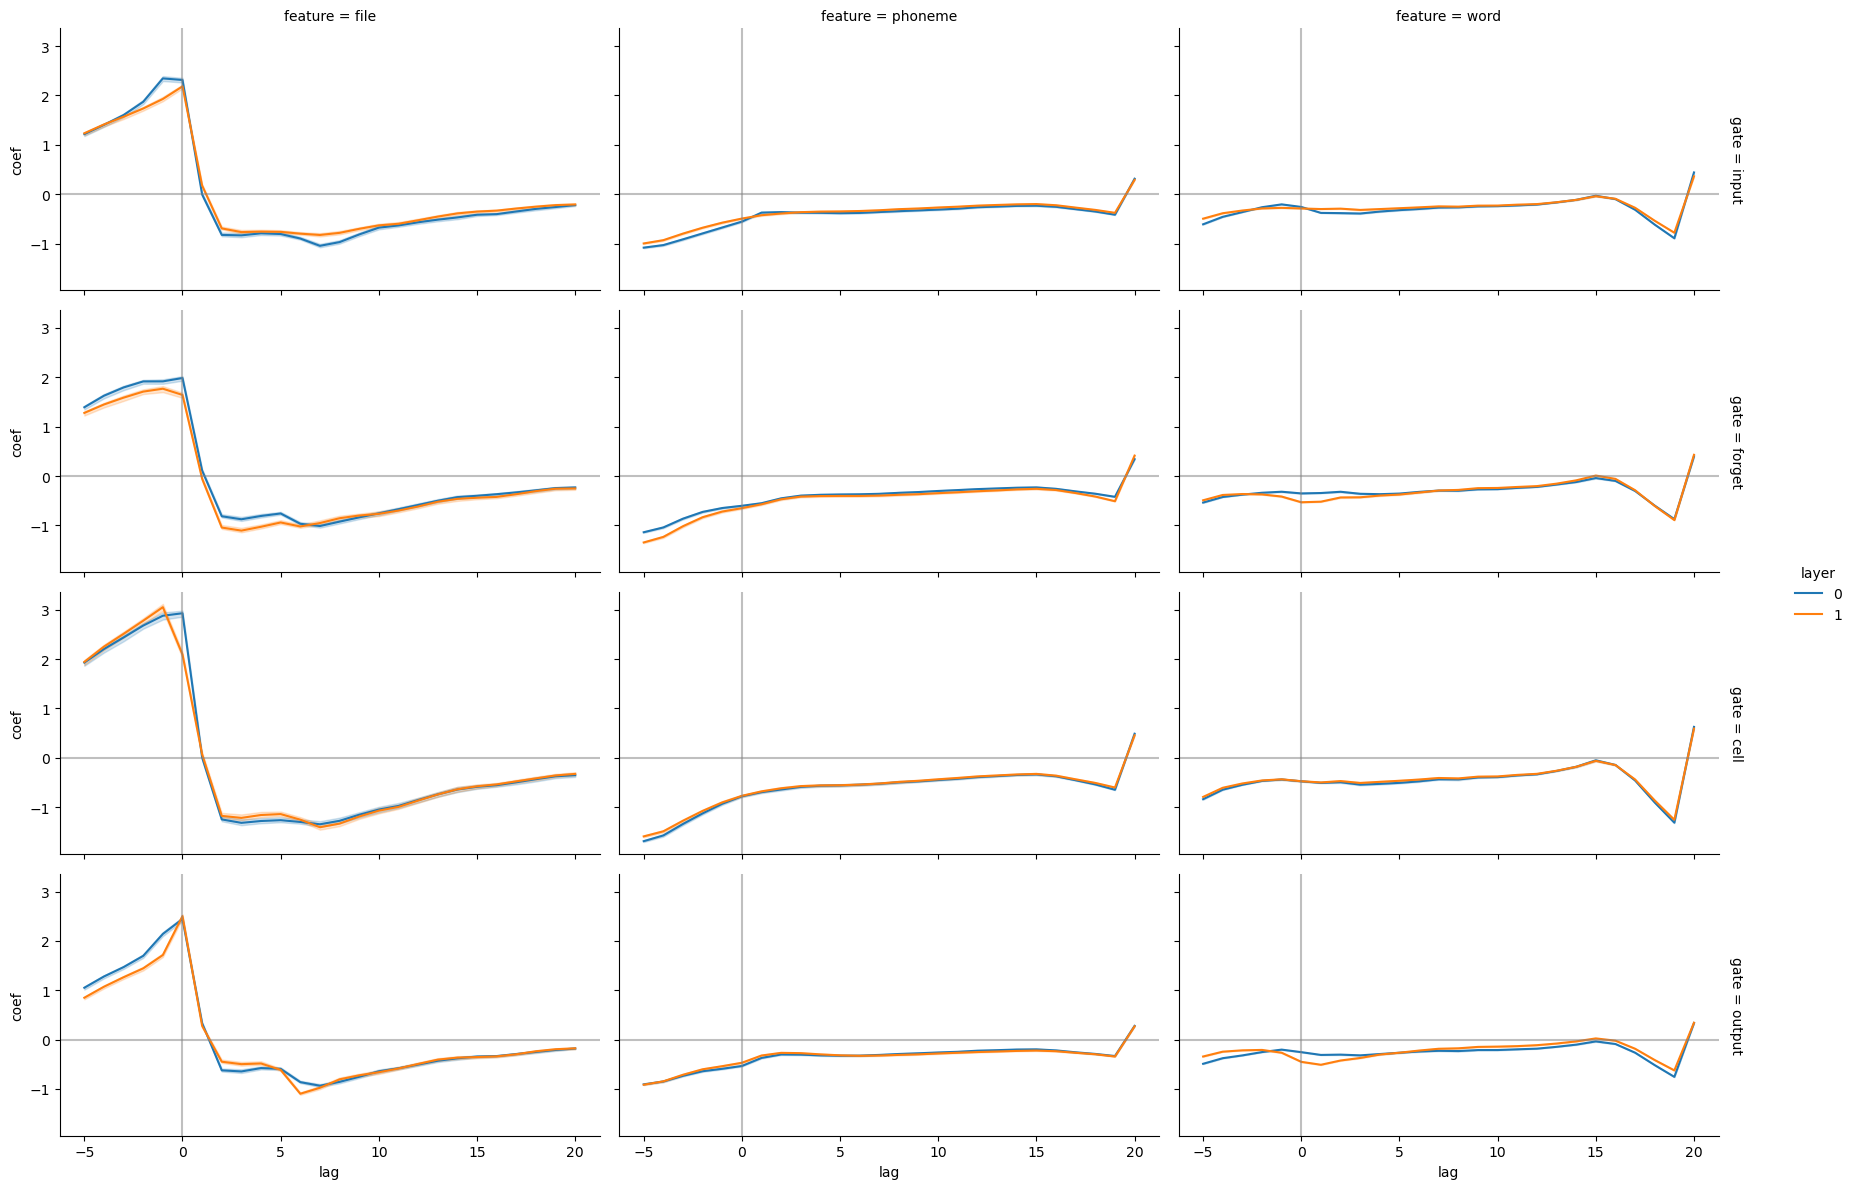

In [215]:
g = sns.FacetGrid(trf_df, row="gate", col="feature", hue="layer", margin_titles=True, aspect=2)
g.map(sns.lineplot, "time", "coef")
g.add_legend()

for ax in g.axes.flat:
    ax.axvline(0, color="gray", alpha=0.5)
    ax.axhline(0, color="gray", alpha=0.5)

## Gate PCA time series analysis

In [159]:
n_components = 2

gate_pcas, gate_pca_labels = [], []
for gate_name, gate in zip(tqdm(["input", "forget", "cell", "output"]),
                           [input_gates, forget_gates, cell_gates, output_gates]):
    for layer in range(gate.shape[1]):
        gate_pcas.append(PCA(n_components=n_components).fit_transform(gate[:, layer]))
        gate_pca_labels.extend([f"{gate_name} {layer} {component}" for component in range(n_components)])

gate_pcas = np.concatenate(gate_pcas, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [225]:
trf_df = estimate_trf_cv(boundary_matrix, gate_pcas, gate_pca_labels,
                         tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(boundary_matrix, gate_pcas,
                                                    test_size=0.2, random_state=42)

trf = ReceptiveField(tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)
trf.fit(X_train, y_train)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

<ReceptiveField | tmin, tmax : (-5.000, 20.000), estimator : <class 'float'>, features : [file, ..., word], fit: True>

In [161]:
trf.score(X_test, y_test)

array([0.00985406, 0.05456934, 0.04551116, 0.00467366, 0.00785906,
       0.04741207, 0.03335897, 0.05127631, 0.00649285, 0.02198061,
       0.0058476 , 0.01609821, 0.03828401, 0.00787135, 0.05112439,
       0.03747744])

In [226]:
# trf_df = pd.DataFrame(trf_to_df(trf, gate_pca_labels))
trf_df[["gate", "layer", "component"]] = trf_df["output_name"].str.split(" ", expand=True)
trf_df["layer_component"] = trf_df["layer"] + " " + trf_df["component"]
trf_df

,fold,level_1,feature,output_name,input_dim,output_dim,lag,time,coef,gate,layer,component,layer_component
0,0,0,file,input 0 0,0,0,-5,-5.0,-0.138143,input,0,0,0 0
1,0,1,file,input 0 0,0,0,-4,-4.0,-0.027539,input,0,0,0 0
2,0,2,file,input 0 0,0,0,-3,-3.0,0.261080,input,0,0,0 0
3,0,3,file,input 0 0,0,0,-2,-2.0,0.766396,input,0,0,0 0
4,0,4,file,input 0 0,0,0,-1,-1.0,2.405770,input,0,0,0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,4,1243,word,output 1 1,2,15,16,16.0,0.261152,output,1,1,1 1
6236,4,1244,word,output 1 1,2,15,17,17.0,0.244247,output,1,1,1 1
6237,4,1245,word,output 1 1,2,15,18,18.0,0.222067,output,1,1,1 1
6238,4,1246,word,output 1 1,2,15,19,19.0,0.204287,output,1,1,1 1


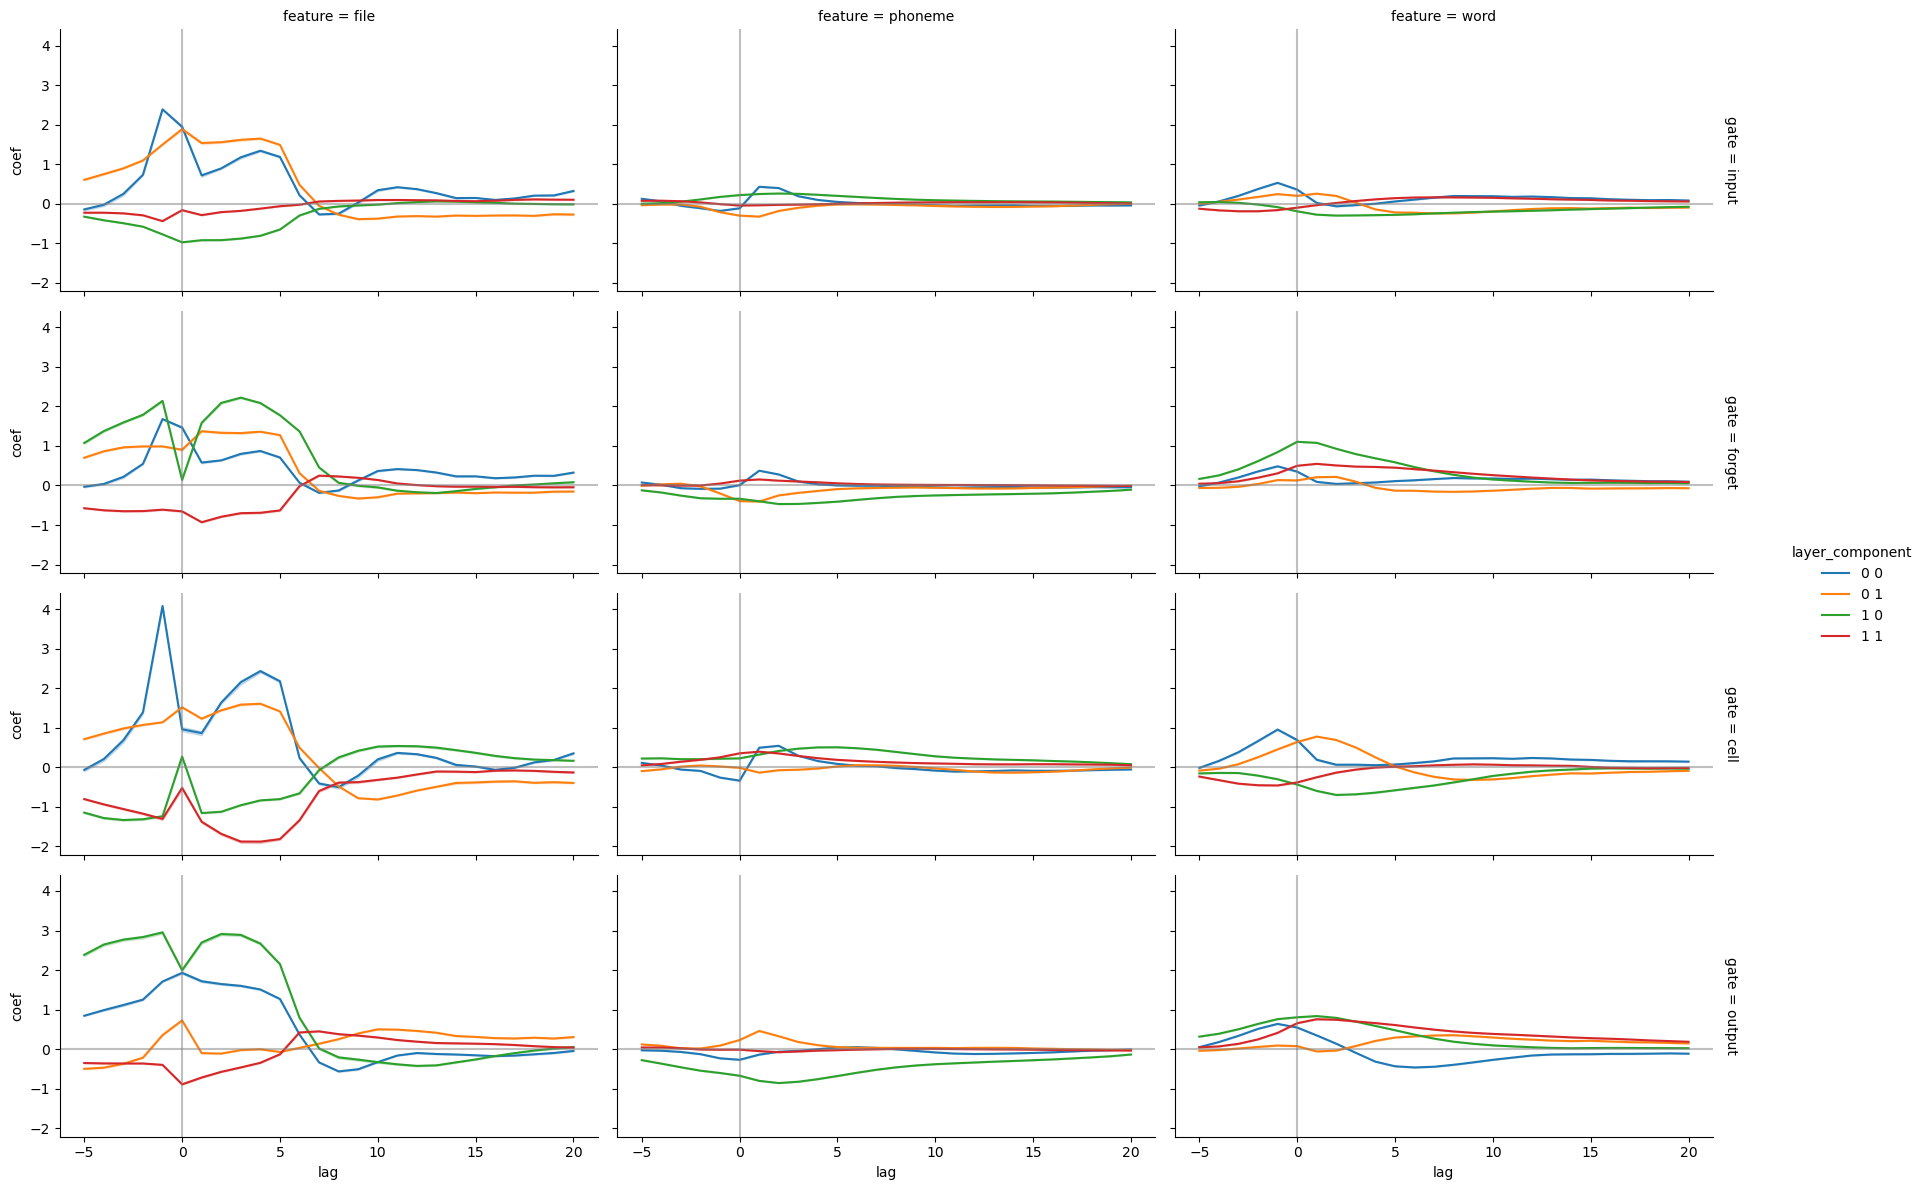

In [227]:
g = sns.FacetGrid(trf_df, row="gate", col="feature", hue="layer_component", margin_titles=True, aspect=2)
g.map(sns.lineplot, "lag", "coef")
g.add_legend()

for ax in g.axes.flat:
    ax.axvline(0, color="gray", alpha=0.5)
    ax.axhline(0, color="gray", alpha=0.5)

## Exploratory peak analysis

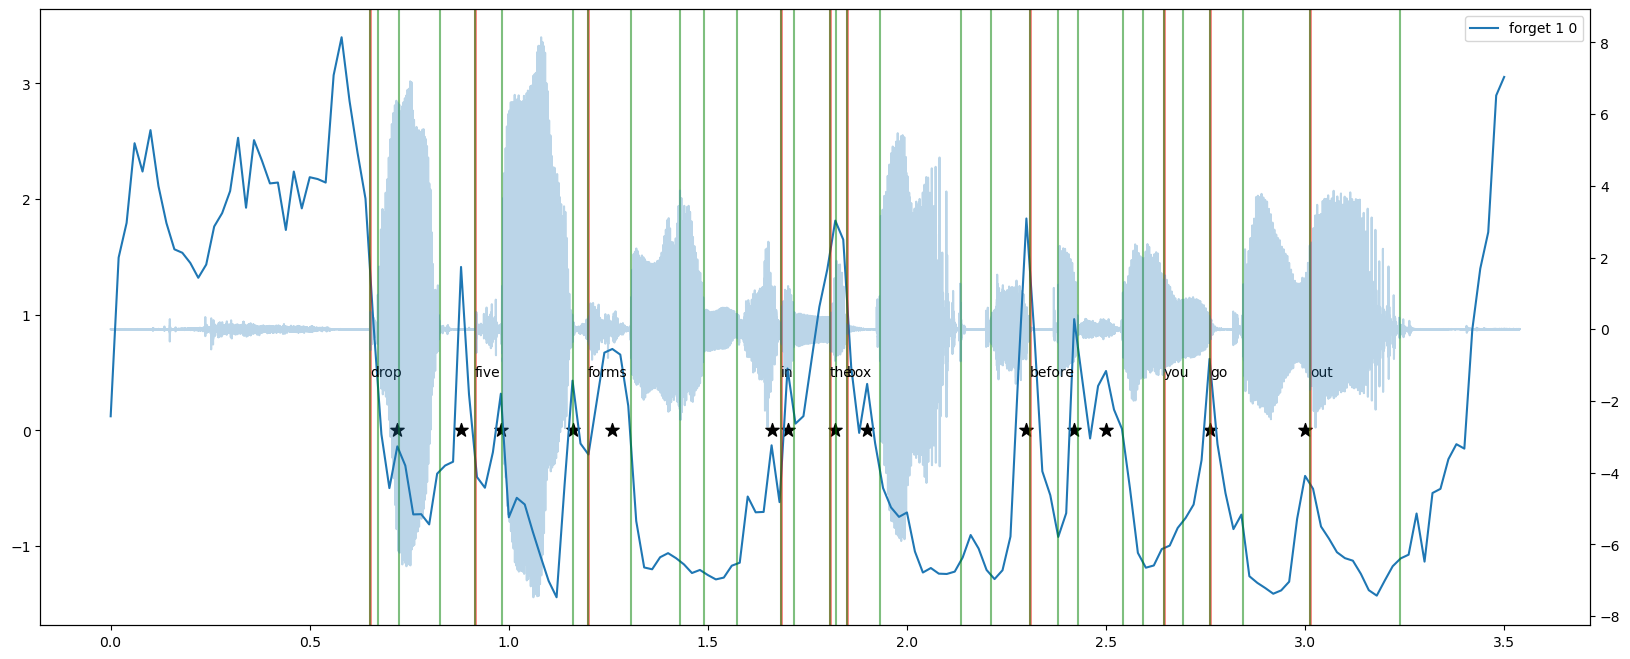

In [319]:
f, ax = plt.subplots(figsize=(20, 8))

plot_item_idx = 7
plot_item = test_dataset_sub[plot_item_idx]
plot_item_flat_idxs = np.array([idx for ((item_idx, frame), idx) in hidden_state_source_to_flat_idx.items()
                                if item_idx == plot_item_idx])
compression_ratio = model.encoder._get_feat_extract_output_lengths(len(plot_item["input_values"])) / len(plot_item["input_values"])
# assert contiguous
assert np.all(np.diff(plot_item_flat_idxs) == 1)
model_sfreq = 50
ts = (plot_item_flat_idxs - plot_item_flat_idxs.min()) / model_sfreq

ax.twinx().plot(np.arange(len(plot_item["input_values"])) / 16000, plot_item["input_values"], alpha=0.3)

# for gate_data, gate_label in zip(gate_norms[plot_item_flat_idxs].T, gate_norm_labels):
#     if "forget 1" in gate_label:
#         ax.plot(ts, gate_data, label=gate_label)
for gate_data, gate_label in zip(gate_pcas[plot_item_flat_idxs].T, gate_pca_labels):
    if "forget 1 0" in gate_label:
        ax.plot(ts, gate_data, label=gate_label)
ax.legend()

for i, word_phons in enumerate(plot_item["word_phonemic_detail"]):
    if not word_phons: continue
    ax.axvline(word_phons[0]["start"] / 16000, color="red", alpha=0.5, linewidth=2)
    ax.text(word_phons[0]["start"] / 16000, 0.5, plot_item["word_detail"]["utterance"][i],
            ha="left", va="center")
    for phon in word_phons:
        ax.axvline(phon["start"] / 16000, color="green", alpha=0.5)

import scipy.signal
# frames bounding utterance
peak_search_start = int(plot_item["word_detail"]["start"][0] * compression_ratio)
peak_search_end = int(plot_item["word_detail"]["stop"][-1] * compression_ratio)
peak_search_flat_idxs = plot_item_flat_idxs[peak_search_start:peak_search_end]
component_norm = gate_pcas[peak_search_flat_idxs, gate_pca_labels.index("forget 1 0")]
component_norm -= component_norm.mean()
component_norm /= component_norm.std()
peak_samples = scipy.signal.find_peaks(component_norm, height=0.1)[0]
peak_times = ts[peak_samples + peak_search_start]
for peak_time in peak_times:
    ax.scatter(peak_time, 0, color="black", marker="*", s=100)

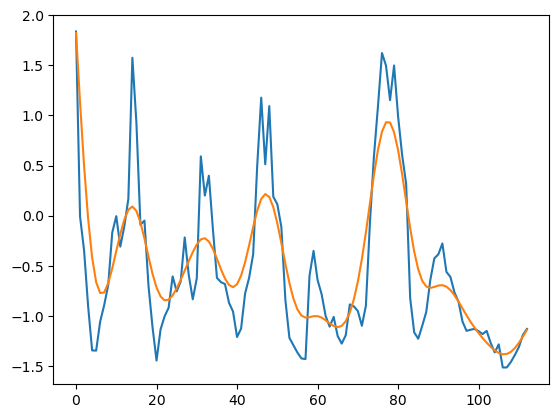

In [285]:
filter_data = gate_pcas[peak_search_flat_idxs, gate_pca_labels.index("forget 1 0")]
plt.plot(filter_data)

nyquist_freq = 50 / 2
b, a = scipy.signal.butter(2, 3 / nyquist_freq, btype="low")
plt.plot(scipy.signal.filtfilt(b, a, filter_data))